In [73]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
import cv2
import sklearn
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [74]:
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

In [75]:
img_size = 48

train_datagen = ImageDataGenerator(width_shift_range = 0.1,height_shift_range = 0.1,
                                    horizontal_flip = True,rescale = 1./255,
                                    validation_split = 0.2)

validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)


In [76]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training")

validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [77]:
model = tf.keras.Sequential([

        # input layer
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,1)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 1st hidden dense layer
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 2nd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 3rd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # Flatten layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        # output layer
        tf.keras.layers.Dense(7, activation='softmax')
    ])

In [78]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 23, 23, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 11, 11, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,841,543 (14.65 MB)

 Trainable params: 3,837,575 (14.64 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [79]:
epochs = 100
batch_size = 64

In [80]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 59s 124ms/step - accuracy: 0.1750 - loss: 9.6398 - val_accuracy: 0.2151 - val_loss: 8.6970
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 93ms/step - accuracy: 0.2178 - loss: 8.5422 - val_accuracy: 0.2591 - val_loss: 7.6454
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.2474 - loss: 7.5928 - val_accuracy: 0.3031 - val_loss: 6.7051
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.2700 - loss: 6.6503 - val_accuracy: 0.3359 - val_loss: 5.8278
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.3068 - loss: 5.7588 - val_accuracy: 0.3457 - val_loss: 5.2167
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.3374 - loss: 4.9787 - val_accuracy: 0.3219 - val_loss: 4.5869
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.3645 - loss: 4.3141 - val_accuracy: 0.3869 - val_loss: 3.9849
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.3928 - loss: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.7153 - loss: 1.2629 - val_accuracy: 0.6795 - val_loss: 1.3828
Epoch 99/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.7094 - loss: 1.2890 - val_accuracy: 0.6948 - val_loss: 1.4145
Epoch 100/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.7173 - loss: 1.2714 - val_accuracy: 0.6620 - val_loss: 1.4175


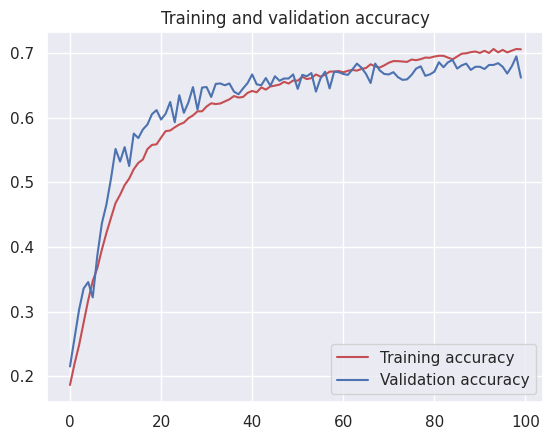

<Figure size 640x480 with 0 Axes>

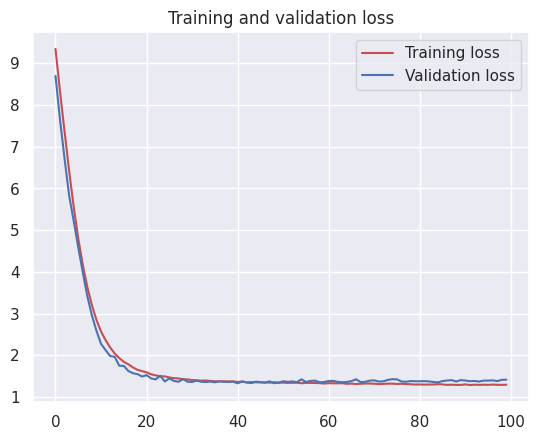

In [81]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [82]:
model.save('model_fer2013.h5')

In [83]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.7659 - loss: 1.1461
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.6464 - loss: 1.4593
final train accuracy = 76.56 , validation accuracy = 66.20


(48, 48)


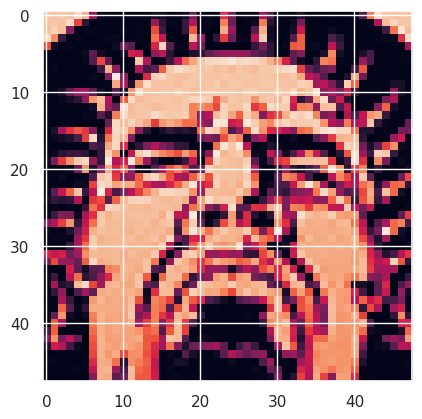

In [84]:
img = image.load_img("/kaggle/input/fer2013/test/fear/PrivateTest_1161501.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [85]:
Classes = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [86]:
img = np.expand_dims(img,axis = 0) 
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [87]:
img_index = result.index(max(result))
print(Classes[img_index])
plt.show()

Fear


In [88]:
model.save_weights('model_weights.weights.h5')

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


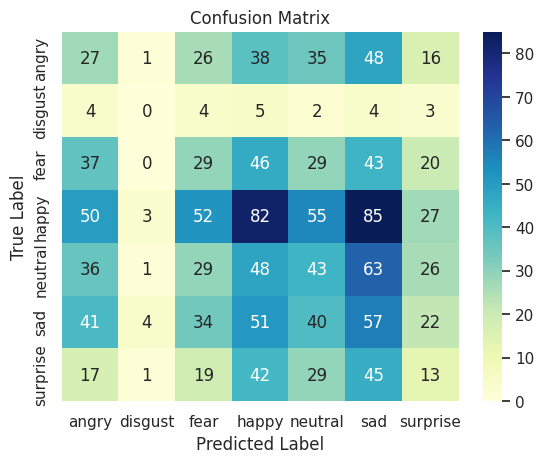

In [89]:
# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()